# 範例 : (Kaggle)房價預測
***
- 以下用房價預測資料, 觀察降低資料偏態的影響

# [教學目標]
- 以下用房價預測資料, 觀察降低偏態的影響

# [範例重點]
- 觀察原始數值的散佈圖, 以及線性迴歸分數 (Out[3], Out[4]) 
- 觀察使用log1p降偏態時, 對於分布與迴歸分數的影響 (In[5], Out[5])
- 觀察使用box-cox(λ=0.15)時, 對於分布與迴歸分數的影響 (In[6], Out[6])
- 觀察使用sqrt(box-cox, λ=0.5)時, 對於分布與迴歸分數的影響 (In[7], Out[7])

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

data_path = '../data/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')
df_test = pd.read_csv(data_path + 'house_test.csv.gz')

train_Y = np.log1p(df_train['SalePrice'])
ids = df_test['Id']
df_train = df_train.drop(['Id', 'SalePrice'] , axis=1)
df_test = df_test.drop(['Id'] , axis=1)
df = pd.concat([df_train,df_test])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [2]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
        
print('%d Numeric Features : %s' %(len(num_features), num_features))
#print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df.head()

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008


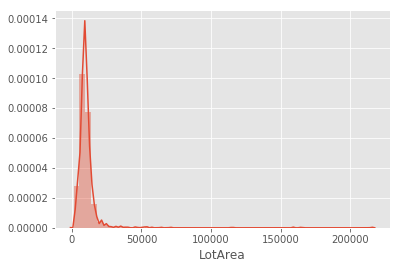

In [3]:
# 顯示 LotArea 的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

sns.distplot(df['LotArea'][:train_num])
plt.show()

In [4]:
# 計算基礎分數
df_mm = MMEncoder.fit_transform(df)
train_X = df_mm[:train_num]
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

C:\Users\tony8\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.8464738883495573

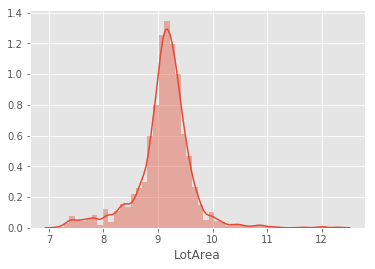

0.852911262961794


C:\Users\tony8\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [5]:
# 將 LotArea 取 log1p 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df)
#copy有分軟拷貝 copy 與 硬拷貝deepcopy 

#軟拷貝只複製內容也複製位置 修改子數值後相互影響
#硬拷貝複製內容但不複製位置 修改數值後也不對方影響

df_fixed['LotArea'] = np.log1p(df_fixed['LotArea'])
sns.distplot(df_fixed['LotArea'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LinearRegression()
print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

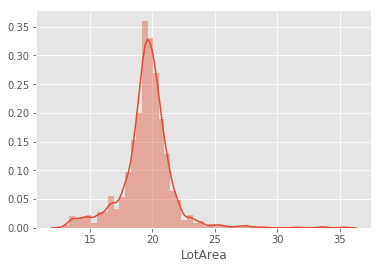

0.852064259070573


C:\Users\tony8\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [6]:
# 將 LotArea 取 boxcox 後, 看散佈圖, 並計算分數
from scipy import stats
df_fixed = copy.deepcopy(df)
df_fixed['LotArea'] = stats.boxcox(df_fixed['LotArea'], lmbda=0.15)
sns.distplot(df_fixed['LotArea'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LinearRegression()
print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

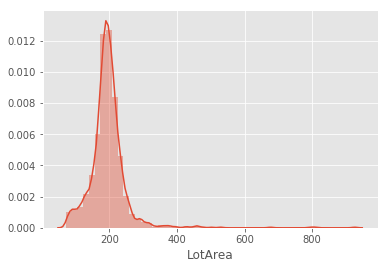

0.8484330344413774


C:\Users\tony8\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [7]:
# 將 LotArea 取 sqrt (box-cox : alpha=0.5) 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df)
df_fixed['LotArea'] = stats.boxcox(df['LotArea'], lmbda=0.5)
sns.distplot(df_fixed['LotArea'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LinearRegression()
print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

# 作業 : (Kaggle)鐵達尼生存預測 
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察降低偏態的影響

# [作業重點]
- 觀察使用log1p降偏態時, 對於分布與迴歸分數的影響 (In[12], Out[12])
- 修正區塊中的資料問題後, 觀察以box-cox降偏態, 對於分布與迴歸分數的影響 (In[13], Out[13])

In [8]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

data_path = '../data/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
        
print("%d Numeric Features : %s" %(len(num_features),num_features))
#print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(0)
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df.head()

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


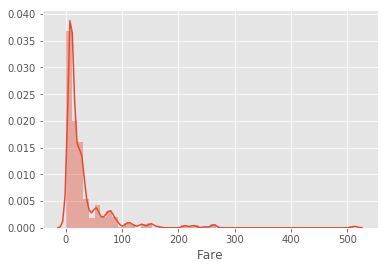

In [10]:
# 顯示 Fare 與目標值的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.distplot(df['Fare'][:train_num])
plt.show()

In [11]:
# 計算基礎分數
df_mm = MMEncoder.fit_transform(df)
train_X = df_mm[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7016289882888318

# 作業1 
* 試著在鐵達尼的票價 (Fare) 欄位中使用對數去偏 (log1p) , 結果是否更好?

**Your answer:** *0.7016 -> 0.7106*

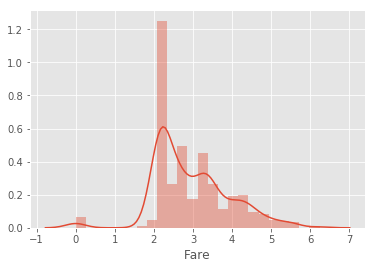

0.7106367963253961

In [12]:
# 將 Fare 取 log1p 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df)
"""
Your Code Here, transform df_fixed['Fare'] with log1p
"""
df_fixed['Fare'] = np.log1p(df_fixed['Fare'])

sns.distplot(df_fixed['Fare'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

# 作業2
* 最後的 boxcox 區塊直接執行會造成錯誤, 起因為輸入值有負值, 請問如何修正後可以使用 boxcox? (Hint : 試圖修正資料)

**Your answer:** *0~1 取log會變成負數*

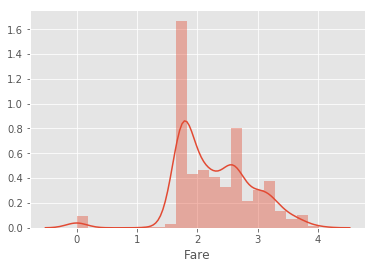

0.7095195488169852

In [13]:
# 將 Fare 取 boxcox 後, 看散佈圖, 並計算分數 (執行會有 error, 請試圖修正)
from scipy import stats
df_fixed = copy.deepcopy(df)
"""
Your Code Here, fix the error
"""
df_fixed['Fare'] = df_fixed['Fare'].clip(1, float('inf'))

df_fixed['Fare'] = stats.boxcox(df_fixed['Fare'])[0] 
#未設定lmbda將會回傳兩個數值 第一個是最佳轉換後的數字 
#第二個是最佳轉換的lmbda值

#df_fixed['Fare'] = stats.boxcox(df_fixed['Fare']+1)[0]

sns.distplot(df_fixed['Fare'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()